In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import pickle

In [3]:
import ipywidgets as widgets
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

2024-04-02 13:50:24.110579: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-02 13:50:24.127403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import torch
from torch import Tensor
from torch.nn import functional as F
from torch.optim import Adam
from torchvision.models.segmentation import (
    DeepLabV3_ResNet101_Weights,
    deeplabv3_resnet101,
)

In [6]:
from srcnn import SRCNN
from visualization import show_image

In [7]:
COCO_HUMAN_ID = 0
COCO_DOG_ID = 16

VOC_BACKGROUND_ID = 0
VOC_PERSON_ID = 15
VOC_DOC_ID = 12

coco = tfds.load("coco/2017", split="validation")
coco = coco.filter(
    lambda x: tf.reduce_any(x["objects"]["label"] == COCO_HUMAN_ID)
    & tf.reduce_any(x["objects"]["label"] == COCO_DOG_ID)
)

resnet = deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.DEFAULT).to("cuda")
resnet.eval()

dataset: list[tuple[Tensor, Tensor]] = []

with torch.inference_mode():
    for element in coco.as_numpy_iterator():
        image = torch.tensor(element["image"], dtype=torch.float32).permute(2, 0, 1)
        resnet_input = image.unsqueeze(0).to("cuda")
        resnet_input /= 255
        target = resnet(resnet_input)["out"].squeeze(0)
        target = target[[VOC_BACKGROUND_ID, VOC_PERSON_ID, VOC_DOC_ID]]
        target = F.softmax(target, dim=0)
        target *= 255
        target = target.cpu().detach()
        dataset.append((image, target))

del coco, resnet, element, image, resnet_input, target
gc.collect()

print("Dataset size:", len(dataset))

Dataset size: 76


In [8]:
model_args = {
    "f1": 9,
    "f2": 1,
    "f3": 5,
    "n1": 64,
    "n2": 32,
    "qconfig": torch.ao.quantization.get_default_qat_qconfig("x86"),
}

In [9]:
model = SRCNN(**model_args).to("cuda")
optimizer = Adam(model.parameters(), lr=4e-4)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
    pin_memory_device="cuda",
)

model.train()
epoch_losses = []
progress_bar = tqdm(range(1, 500 + 1))
for epoch in progress_bar:
    batch_losses = []

    for inputs, targets in dataloader:
        inputs, targets = inputs.to("cuda"), targets.to("cuda")
        outputs = model(inputs, quant=False)
        loss = F.cross_entropy(outputs / 255, targets / 255)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    progress_bar.set_postfix(epoch_loss=epoch_loss)

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        model.eval()
        with torch.inference_mode():
            torch.save(model.state_dict(), "best.pth")

    epoch_losses.append(epoch_loss)

100%|██████████| 500/500 [02:07<00:00,  3.93it/s, epoch_loss=0.484] 


Text(0, 0.5, 'Loss')

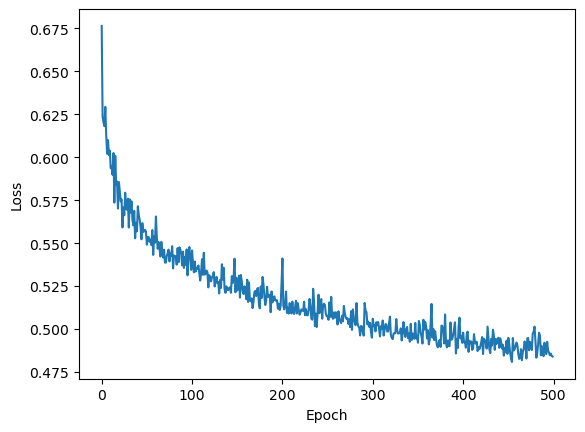

In [10]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [11]:
model = SRCNN(**model_args).to("cuda")
model.eval()
model.load_state_dict(torch.load("best.pth"))
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
optimizer = Adam(model_qat.parameters(), lr=1e-4)

epoch_losses = []
progress_bar = tqdm(range(1, 500 + 1))
for epoch in progress_bar:
    batch_losses = []

    for inputs, targets in dataloader:
        inputs, targets = inputs.to("cuda"), targets.to("cuda")
        outputs = model_qat(inputs, quant=True)
        loss = F.cross_entropy(outputs / 255, targets / 255)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    progress_bar.set_postfix(epoch_loss=epoch_loss)

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        model_qat.eval()
        with torch.inference_mode():
            torch.save(model_qat.state_dict(), "best_qat.pth")

    epoch_losses.append(epoch_loss)

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
  0%|          | 0/500 [00:00<?, ?it/s]/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax

Text(0, 0.5, 'Loss')

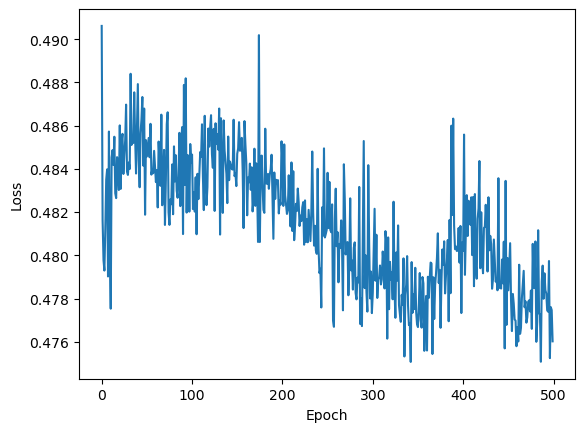

In [12]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [13]:
model = SRCNN(**model_args).to("cuda")
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.load_state_dict(torch.load("best_qat.pth"))
model_qat.cpu()
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
torch.save(model_converted.state_dict(), "converted.pth")

In [14]:
%matplotlib inline

model = SRCNN(**model_args)
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
model_converted.load_state_dict(torch.load("converted.pth"))

FIGURE_SIZE = (12, 8)

def animate_dataset(index):
    _, input_axes = plt.subplots(1, 1, figsize=FIGURE_SIZE)
    input_axes.set_title("Input")
    _, output_axes = plt.subplots(1, 1, figsize=FIGURE_SIZE)
    output_axes.set_title("Output")
    _, target_axes = plt.subplots(1, 1, figsize=FIGURE_SIZE)
    target_axes.set_title("Target")

    test_input, test_target = dataset[index]
    test_output = model_converted(test_input.unsqueeze(0), quant=True).squeeze(0)
    print(type(test_output), test_output.shape)
    show_image(input_axes, test_input)
    show_image(output_axes, test_output)
    show_image(target_axes, test_target)


widgets.interact(animate_dataset, index=(0, len(dataset) - 1, 1))

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/_utils.py:404: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


interactive(children=(IntSlider(value=37, description='index', max=75), Output()), _dom_classes=('widget-inter…

<function __main__.animate_dataset(index)>

In [15]:
s = [21, 13, 14]

u = []
v = []
weights = []

x_scale_keys = ["quant.scale", "conv_layers.0.scale", "conv_layers.1.scale"]
x_zero_point_keys = [
    "quant.zero_point",
    "conv_layers.0.zero_point",
    "conv_layers.2.zero_point",
]

for i in range(3):
    conv_layers_weight = model_converted.state_dict()[f"conv_layers.{i}.weight"]
    bias = model_converted.state_dict()[f"conv_layers.{i}.bias"]

    x_scale = model_converted.state_dict()[x_scale_keys[i]]
    y_scale = model_converted.state_dict()[f"conv_layers.{i}.scale"]
    A_scale = conv_layers_weight.q_per_channel_scales()

    u.append(x_scale / y_scale * A_scale * (2 ** s[i]))
    v.append((bias / y_scale) * (2 ** s[i]))

    A_q = conv_layers_weight.int_repr()
    x_0 = model_converted.state_dict()[x_zero_point_keys[i]]

    weight = A_q * u[i].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    weights.append(weight)

weights[0] = weights[0] / model_converted.state_dict()["quant.scale"]
weights[2] = weights[2] * y_scale

Text(0.5, 1.0, 'Output')

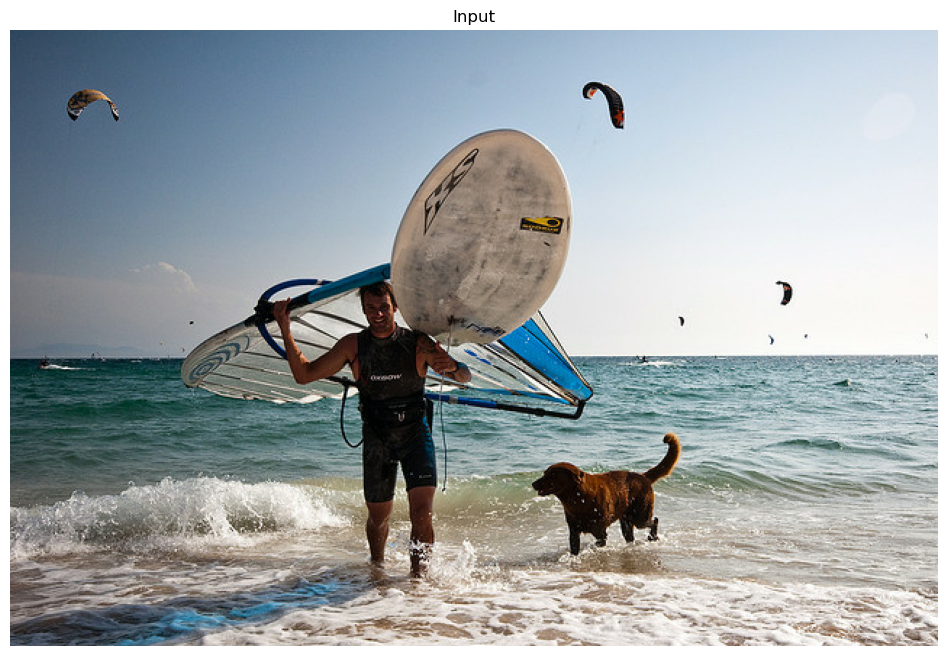

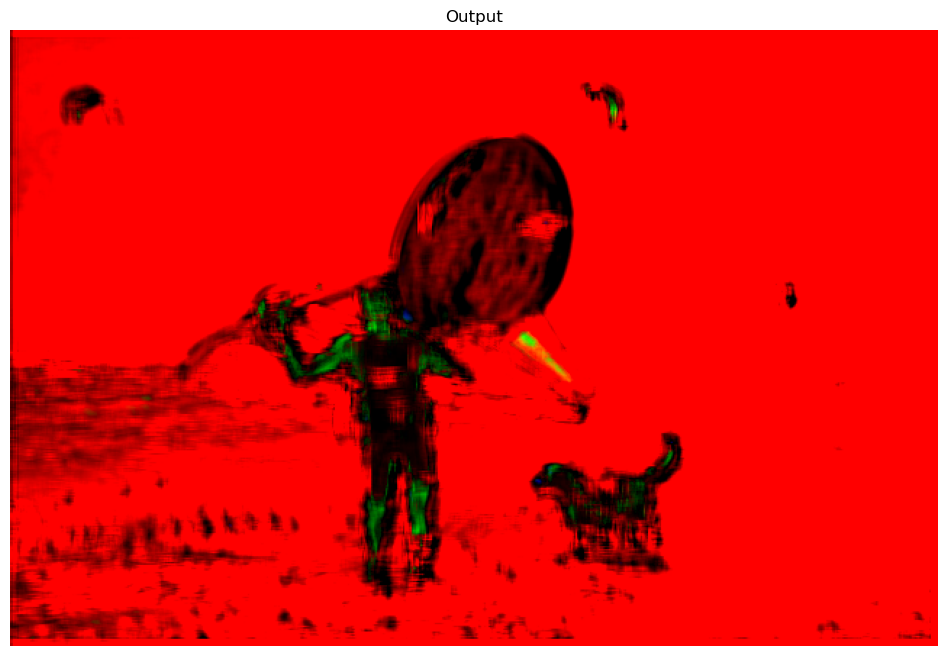

In [16]:
ACTIVATION_SHIFT = 2

ACTIVATION_WIDTH = 16
ACTIVATION_MIN = -(2 ** (ACTIVATION_WIDTH - 1))
ACTIVATION_MAX = 2 ** (ACTIVATION_WIDTH - 1) - 1

WEIGHT_WIDTH = 25
WEIGHT_MIN = -(2 ** (WEIGHT_WIDTH - 1))
WEIGHT_MAX = 2 ** (WEIGHT_WIDTH - 1) - 1

DSP_OUTPUT_WIDTH = 48
DSP_OUTPUT_MIN = -(2 ** (DSP_OUTPUT_WIDTH - 1))
DSP_OUTPUT_MAX = 2 ** (DSP_OUTPUT_WIDTH - 1) - 1

test_input = dataset[0][0].unsqueeze(0)
test_output = test_input.double() * (2**ACTIVATION_SHIFT)

for i, weight in enumerate(weights):
    assert weight.min() >= WEIGHT_MIN, f"Weight {i} min: {weight.min()}"
    assert weight.max() <= WEIGHT_MAX, f"Weight {i} max: {weight.max()}"

    test_output = (
        F.conv2d(
            test_output, weight.double().round(), v[i].double().round(), padding="same"
        )
        .double()
        .round()
    )
    assert test_output.min() >= DSP_OUTPUT_MIN, f"Output {i} min: {test_output.min()}"
    assert test_output.max() <= DSP_OUTPUT_MAX, f"Output {i} max: {test_output.max()}"

    test_output = F.relu(test_output * (2 ** -s[i])).double().floor()
    assert test_output.min() >= ACTIVATION_MIN, f"Output {i} min: {test_output.min()}"
    assert test_output.max() <= ACTIVATION_MAX, f"Output {i} max: {test_output.max()}"

test_output = (test_output * (2**-ACTIVATION_SHIFT)).double().floor()

_, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
show_image(ax, test_input)
plt.title("Input")

_, ax = plt.subplots(1, 1, figsize=FIGURE_SIZE)
show_image(ax, test_output)
plt.title("Output")

In [17]:
with open("weights.pkl", "wb") as fp:
    pickle.dump(weights, fp)
with open("biases.pkl", "wb") as fp:
    pickle.dump(v, fp)